# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 100 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size, ablation = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    #Since back-to-back frames will have similar information we can choose only the even frames
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        if ablation==True: 
          f = np.random.permutation(folder_list)
          t = np.random.choice(f, 10) # work with only 10 folders for ablation
        else:
          t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                   
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)


                    #Normalizing using the mean of the 3 channels.
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [6]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [20]:
def train_model(model, folder, save_name, epochs, ablation=False):
    
    # Compile Model
    sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-2, momentum=0.7, nesterov=True)
    #adam = tf.keras.optimizers.Adam()
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

    # Set Folders and Filenames

    model_name = 'model_output/'+folder+'/'+ save_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.makedirs(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    # Set Check Points
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
    callbacks_list = [checkpoint, LR]

    #Set params

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    # Run Generator

    train_generator = generator(train_path, train_doc, batch_size, ablation=ablation)
    val_generator = generator(val_path, val_doc, batch_size, ablation=ablation)

    # Run ablation for EPOCHS
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

    plot_loss_accuracy(history)    

## Model

Here you make the model using different functionalities that Keras provides. You might want to use `TimeDistributed`, `GRU` and other RNN structures after doing transfer learning. Also remember that the last layer is the softmax. Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

In [53]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras import optimizers
# from tensorflow.keras.applications.resnet50 import ResNet50
    
# base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(120,120,3))
# x = base_model.output
# x = Flatten()(x)
# #x.add(Dropout(0.5))
# features = Dense(64, activation='relu')(x)
# conv_model = Model(inputs=base_model.input, outputs=features)
    
# for layer in base_model.layers:
#     layer.trainable = False
        
# model = Sequential()
# model.add(TimeDistributed(conv_model, input_shape=(18,120,120,3)))
# model.add(GRU(32, return_sequences=True))
# model.add(GRU(16))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='relu'))
# #model.add(Dropout(0.5))
# #model.add((Flatten()))
# model.add(Dense(5, activation='softmax'))

## Model Convo 3D
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, GlobalAveragePooling2D, GlobalAveragePooling3D, ZeroPadding3D, BatchNormalization, Activation, Dropout, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
input_shape = (18, 120, 120, 3)

model = Sequential()

model.add(Conv3D(128, (3,3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

2023-10-06 10:10:08.340338: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-06 10:10:08.340420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5


### Running Abalations and trying to overfit the Convo3D model. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 120, 120, 128  10496     
                             )                                   
                                                                 
 batch_normalization (BatchN  (None, 18, 120, 120, 128  512      
 ormalization)               )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 60, 60, 128)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 60, 60, 64)     221248    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 60, 60, 64)    256       
 hNormalization)                                        

2023-10-06 10:10:17.999566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


7/7 [==============================] - ETA: 0s - loss: 12.8330 - categorical_accuracy: 0.2143Source path =  /home/datasets/Project_data/val ; batch size = 100

Epoch 00001: saving model to model_output/Convo3D/convo3D_2023-10-0610_09_53.179992/model-00001-12.83300-0.21429-213.65068-0.40000.h5
7/7 [==============================] - 13s 1s/step - loss: 12.8330 - categorical_accuracy: 0.2143 - val_loss: 213.6507 - val_categorical_accuracy: 0.4000 - lr: 0.0100
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 2.1518 - categorical_accuracy: 0.3286
Epoch 00002: saving model to model_output/Convo3D/convo3D_2023-10-0610_09_53.179992/model-00002-2.15179-0.32857-59.49271-0.30000.h5
7/7 [==============================] - 9s 1s/step - loss: 2.1518 - categorical_accuracy: 0.3286 - val_loss: 59.4927 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 1.8807 - categorical_accuracy: 0.3571
Epoch 00003: saving model to model_

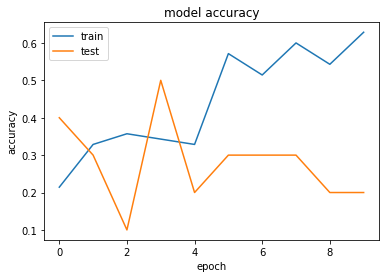

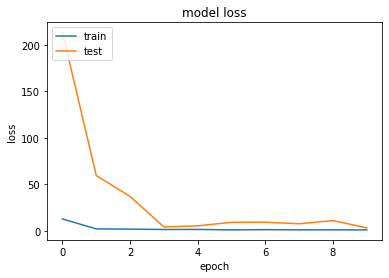

In [9]:
train_model(model, 'Convo3D', 'convo3D', 10, True )

#### The Model is able to overfir with a small sample of 10 folders and 10 EPOCHS
#### Lets Modify the Model and try and decrease the params. 

In [10]:
input_shape = (18, 120, 120, 3)

model = Sequential()

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 18, 120, 120, 64)  5248      
                                                                 
 batch_normalization_3 (Batc  (None, 18, 120, 120, 64)  256      
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 60, 60, 64)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 9, 60, 60, 32)     55328     
                                                                 
 batch_normalization_4 (Batc  (None, 9, 60, 60, 32)    128       
 hNormalization)                                                 
                                                      

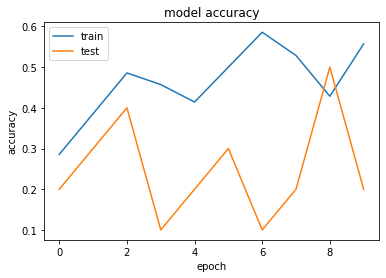

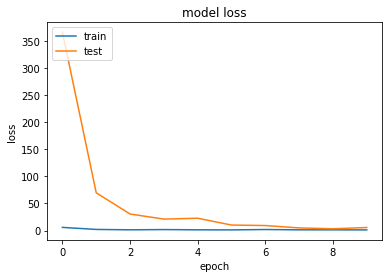

In [11]:
train_model(model, 'Convo3D', 'convo3D', 10, True )

In [12]:
### Model is still overfitting
## Modifing Params again. 

input_shape = (18, 120, 120, 3)

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(16, (3, 3,3), padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 18, 120, 120, 32)  2624      
                                                                 
 batch_normalization_6 (Batc  (None, 18, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 9, 60, 60, 32)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 9, 60, 60, 16)     13840     
                                                                 
 batch_normalization_7 (Batc  (None, 9, 60, 60, 16)    64        
 hNormalization)                                                 
                                                      

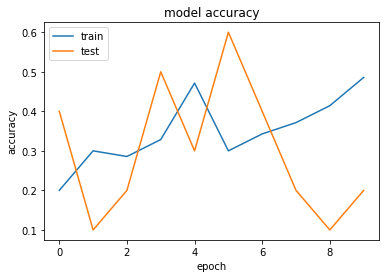

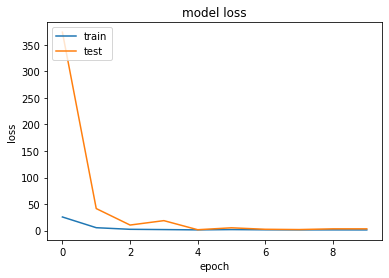

In [13]:
train_model(model, 'Convo3D', 'convo3D-model3', 10, True )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 18, 120, 120, 32)  2624      
                                                                 
 batch_normalization_6 (Batc  (None, 18, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 9, 60, 60, 32)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 9, 60, 60, 16)     13840     
                                                                 
 batch_normalization_7 (Batc  (None, 9, 60, 60, 16)    64        
 hNormalization)                                                 
                                                      

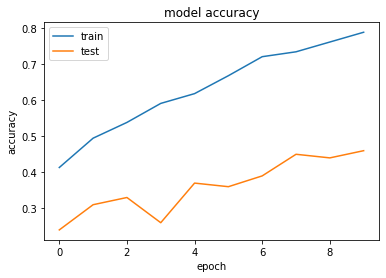

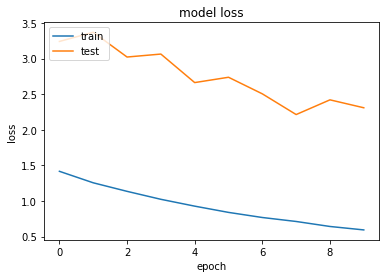

In [14]:
# Tryig to ru the same with full data for 5 epochs

train_model(model, 'Convo3D', 'convo3D-model3', 10, False )

#### Model is Still overfitting a bit although the loss is at a decreasing trend and it will decrease if we run this for more epochs
#### Lets try and add LSTM layers to the 3D Convo

## 3D Convo with LSTM

In [25]:
from keras.layers import ConvLSTM3D, Bidirectional, LSTM, Reshape
from keras.models import Sequential
input_shape = (18, 120, 120, 3)

model = Sequential()

model.add(ConvLSTM3D(32, (3, 3, 3), input_shape=input_shape, activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(ConvLSTM3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(ConvLSTM3D(128, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

shape = model.layers[-1].output_shape
model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(.5))

model.add((Flatten()))

model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(5, activation='softmax'))

ValueError: Input 0 of layer "conv_lstm3d_1" is incompatible with the layer: expected ndim=6, found ndim=5. Full shape received: (None, 18, 120, 120, 3)